# Modeling Dynamical Systems
For instructions on how to run these tutorial notebooks, please see the [index](./index.ipynb).


This notebook provides a short tutorial for modeling input-output dynamical systems in Drake.  It covers
- Writing your own simple dynamical systems,
- Simulating a dynamical system and plotting the results,
- Constructing a block diagram out of simple systems.

Drake includes a set of C++ classes in drake::systems that provide an API for building complex dynamical systems by connecting simple dynamical systems into a block diagram. The modeling approach is inspired by MATLAB's Simulink (though without the graphical user interface). Like Simulink, drake::systems provides a library of existing systems and also makes it easy for you to define your own new dynamical systems. The Python wrappers in `pydrake` used in these notes provide a convenient set of bindings on top of this systems framework, allowing you to write new systems in either Python or C++, and to use them interchangeably.

A major difference between modeling dynamical systems in Drake vs Simulink (or most other system modeling languages) is that there is a considerable emphasis in Drake on introspecting the underlying structure in the governing equations. For example, if certain outputs of a dynamical system depend on only a small fraction of the inputs, then we attempt to infer this sparsity directly. Similarly, if the dynamics of a system can be described by a polynomial vector field (or linear, or at least differentiable, ...), then Drake aims to infer this structure as well, and to preserve this structure when systems are combined into a diagram. This structure may have only modest benefit for numerical simulation, but it is incredibly enabling for more sophisticated algorithms for analysis, system identification, and feedback or state estimator design.

We'll return to the more advanced modeling tools in a minute, but let us start with some very simple examples.

A quick note on documentation. The C++ classes are beautifully documented in [doxygen](http://drake.mit.edu/doxygen_cxx).  The Python API is also [documented](https://drake.mit.edu/pydrake/index.html) directly, but is autogenerated and not always as beautiful.  Consider using the C++ doxygen as a secondary source of documentation even for your Python development... most of the `pydrake` API maps directly to that C++ API.

## A library of dynamical systems

Drake provides a [rich library of dynamical
systems](https://drake.mit.edu/doxygen_cxx/group__systems.html) for you to
build on.  These include primitive systems like integrators and multiplexers,
as well as more advanced systems that implement the physics engine, or more
advanced algorithms for estimation and control.  As we will see below, these
building blocks can be combined into more complicated systems.  However, Drake
also makes it easy to write your own systems (in C++ or directly in Python).  

## Writing your own dynamics

In this section, we will describe how you can write your own dynamics class in `pydrake`. Every user system should derive from the `pydrake.systems.framework.LeafSystem` class.

However, many dynamical systems we are interested in are represented by a simple vector field in state-space form, where we often use x to denote the state vector, u for the input vector, and y for the output vector. To make it even easier to implement systems in this form, we provide another subclass `pydrake.systems.primitives.SymbolicVectorSystem` that makes it very easy to author these simple systems.

<!-- The following HTML table format was modified from the doxygen System block output, with the goal of matching the style -->
<table align="center" cellpadding="0" cellspacing="0">
<tr align="center">
<td><table cellspacing="0" cellpadding="0">
<tr>
<td align="right" style="padding:5px 0px 5px 0px">u &rarr; </td></tr>
</table>
</td><td align="center" style="border:solid;padding-left:20px;padding-right:20px" bgcolor="#F0F0F0">System</td><td><table cellspacing="0" cellpadding="0">
<tr>
<td align="left" style="padding:5px 0px 5px 0px">&rarr; y </td></tr>
</table>
</td></tr>
</table>

### Using SymbolicVectorSystem

Consider a basic continuous-time, nonlinear, input-output dynamical system described by the following state-space equations: 

$\begin{aligned}\dot{x} =& f(t,x,u), \\ y =& g(t,x,u).\end{aligned}$

In `pydrake`, you can instantiate a system of this form where $f()$ and $g()$ are anything that you can write in Python using [operations supported by the Drake symbolic engine](https://drake.mit.edu/pydrake/pydrake.symbolic.html#pydrake.symbolic.Expression), as illustrated by the following example.

Consider the system 

$\begin{aligned}\dot{x} =& -x + x^3,\\ y =& x.\end{aligned}$

This system has zero inputs, one (continuous) state variable, and one output.  It can be implemented in Drake using the following code:

In [1]:
from pydrake.symbolic import Variable
from pydrake.systems.primitives import SymbolicVectorSystem

# Define a new symbolic Variable
x = Variable("x")

# Define the System.  
continuous_vector_system = SymbolicVectorSystem(state=[x], dynamics=[-x + x**3], output=[x])


That's it!  The `continuous_vector_system` variable is now an instantiation of a Drake `System` class, that can be used in a number of ways that we will illustrate below.  Note that the state argument expects a *vector* of `symbolic::Variable` (Python lists get automatically converted), and the dynamics and output arguments expect a vector of `symbolic::Expression`s.

Implementing a basic discrete-time system in Drake is very analogous to implementing a continuous-time system.  The discrete-time system given by: 

$\begin{gathered}  x[n+1] = f(n,x,u),\\ y[n] = g(n,x,u), \end{gathered}$ 

can be implemented as seen in the following example.

Consider the system 

$\begin{gathered}x[n+1] = x^3[n],\\ y[n] = x[n].\end{gathered}$

This system has zero inputs, one (discrete) state variable, and one output.  It can be implemented in Drake using the following code:

In [2]:
from pydrake.symbolic import Variable
from pydrake.systems.primitives import SymbolicVectorSystem

# Define a new symbolic Variable
x = Variable("x")

# Define the System.  Note the additional argument specifying the time period.
discrete_vector_system = SymbolicVectorSystem(state=[x], dynamics=[x**3], output=[x], time_period=1.0)

### Deriving from LeafSystem

Although using SymbolicVectorSystems are a nice way to get started, in fact Drake supports authoring a wide variety of systems with multiple inputs and outputs, mixed discrete- and continuous- dynamics, hybrid dynamics with guards and resets, systems with constraints, and even stochastic systems.  To expose more of the underlying system framework, you can derive your system from `pydrake.systems.framework.LeafSystem` directly, instead of using the simplified `SymbolicVectorSystem` interface. 

In [3]:
from pydrake.systems.framework import LeafSystem

# Define the system.
class SimpleContinuousTimeSystem(LeafSystem):
    def __init__(self):
        LeafSystem.__init__(self)

        state_index = self.DeclareContinuousState(1)  # One state variable.
        self.DeclareStateOutputPort("y", state_index)  # One output: y=x.

    # xdot(t) = -x(t) + x^3(t)
    def DoCalcTimeDerivatives(self, context, derivatives):
        x = context.get_continuous_state_vector().GetAtIndex(0)
        xdot = -x + x**3
        derivatives.get_mutable_vector().SetAtIndex(0, xdot)

# Instantiate the System
continuous_system = SimpleContinuousTimeSystem()


# Define the system.
class SimpleDiscreteTimeSystem(LeafSystem):
    def __init__(self):
        LeafSystem.__init__(self)

        state_index = self.DeclareDiscreteState(1)  # One state variable.
        self.DeclareStateOutputPort("y", state_index)  # One output: y=x.
        self.DeclarePeriodicDiscreteUpdateEvent(
            period_sec=1.0,  # One second time step.
            offset_sec=0.0,  # The first event is at time zero.
            update=self.Update) # Call the Update method defined below.

    # x[n+1] = x^3[n]
    def Update(self, context, discrete_state):
        x = context.get_discrete_state_vector().GetAtIndex(0)
        x_next = x**3
        discrete_state.get_mutable_vector().SetAtIndex(0, x_next)

# Instantiate the System
discrete_system = SimpleDiscreteTimeSystem()

This code implements the same systems we implemented above.  Unlike the `SymbolicVectorSystem` version, you can type any valid Python/numpy code into the methods here -- it need not be supported by `pydrake.symbolic`.  Also, we now have the opportunity to overload many more pieces of functionality in `LeafSystem`, to produce much more complex systems (with multiple input and output ports, mixed discrete- and continuous- state, more structured state, hybrid systems with witness functions and reset maps, etc).  But declaring a `LeafSystem` this way does not provide support for Drake's autodiff and symbolic tools out of the box; to do that we need to add [a few more lines to support templates](https://drake.mit.edu/pydrake/pydrake.systems.scalar_conversion.html?highlight=templatesystem#pydrake.systems.scalar_conversion.TemplateSystem).

We also supply a [number of other helper classes and methods](https://drake.mit.edu/doxygen_cxx/group__systems.html) that derive from or construct a `LeafSystem`, such as the [`pydrake.systems.primitives.LinearSystem`](https://drake.mit.edu/pydrake/pydrake.systems.primitives.html?highlight=linearsystem#pydrake.systems.primitives.LinearSystem) class or the [`pydrake.systems.primitives.Linearize()`](https://drake.mit.edu/pydrake/pydrake.systems.primitives.html?highlight=linearize#pydrake.systems.primitives.Linearize) method.  And in many cases, like simulating the dynamics and actuators/sensors of robots, most of the classes that you need have already been implemented.

For more examples of using the more advanced features of `LeafSystem`, consider reading the [Authoring leaf systems tutorial](./authoring_leaf_systems.ipynb) next. 

## Simulation

Once you have acquired a `System` object describing the dynamics of interest, the most basic thing that you can do is to simulate it.  This is accomplished with the `pydrake.framework.analysis.Simulator` class. This class provides access to a rich suite of numerical integration routines, with support for variable-step integration, stiff solvers, and event detection.

In order to view the data from a simulation after the simulation has run, you should add a `pydrake.framework.primitives.VectorLogSink` system to your diagram.

Use the following code to simulate the continuous time system we defined above, and plot the results:

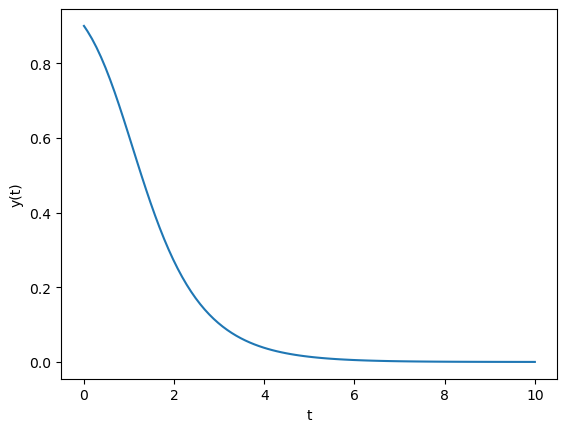

In [4]:
import matplotlib.pyplot as plt
from pydrake.systems.analysis import Simulator
from pydrake.systems.framework import DiagramBuilder
from pydrake.systems.primitives import LogVectorOutput

# Create a simple block diagram containing our system.
builder = DiagramBuilder()
system = builder.AddSystem(SimpleContinuousTimeSystem())
logger = LogVectorOutput(system.get_output_port(0), builder)
diagram = builder.Build()

# Set the initial conditions, x(0).
context = diagram.CreateDefaultContext()
context.SetContinuousState([0.9])

# Create the simulator, and simulate for 10 seconds.
simulator = Simulator(diagram, context)
simulator.AdvanceTo(10)

# Plot the results.
log = logger.FindLog(context)
plt.figure()
plt.plot(log.sample_times(), log.data().transpose())
plt.xlabel('t')
plt.ylabel('y(t)');

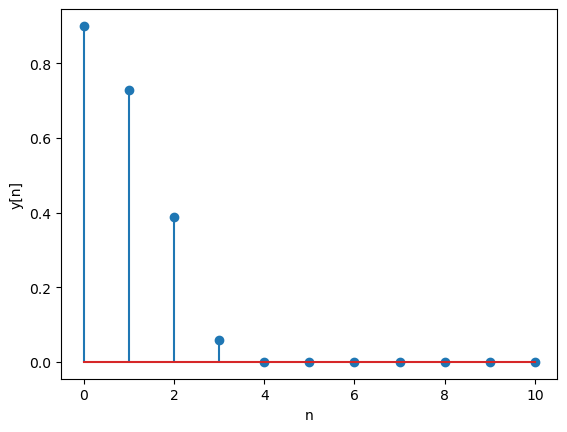

In [5]:
# Create a simple block diagram containing our system.
builder = DiagramBuilder()
system = builder.AddSystem(SimpleDiscreteTimeSystem())
logger = LogVectorOutput(system.get_output_port(0), builder)
diagram = builder.Build()

# Create the simulator.
simulator = Simulator(diagram)

# Set the initial conditions, x(0).
state = simulator.get_mutable_context().get_mutable_discrete_state_vector()
state.SetFromVector([0.9])

# Simulate for 10 seconds.
simulator.AdvanceTo(10)

# Plot the results.
log = logger.FindLog(simulator.get_context())
plt.figure()
plt.stem(log.sample_times(), log.data().transpose())
plt.xlabel('n')
plt.ylabel('y[n]');

Go ahead and try using the `SymbolicVectorSystem` versions instead.  They work, too.

For many systems, the simulation will run much faster than real time.  If you would like to tell the simulator to slow down (if possible) to some multiple of the real time clock, then consider using the `set_target_realtime_rate()` method of the `Simulator`.  This is useful, for example, if you are trying to animate your robot as it simulates, and would like the benefit of physical intuition, or if you are trying to use the simulation as a part of a multi-process real-time control system.

## The System "Context"

If you were looking carefully, you might have noticed a few instances of the word "context" in the code snippets above.  The [`Context`](http://drake.mit.edu/doxygen_cxx/classdrake_1_1systems_1_1_context.html) is a core concept in the Drake systems framework: the `Context` captures all of the (potentially) dynamic information that a `System` requires to implement its core methods: this includes the time, the state, any inputs, and any system parameters.  The `Context` of a `System` is everything you need to know for simulation (or control design, ...), and given a `Context` all methods called on a `System` should be completely deterministic/repeatable.

`System`s know how to create an instance of a `Context` (see [CreateDefaultContext](https://drake.mit.edu/doxygen_cxx/classdrake_1_1systems_1_1_system.html#ad047317ab91889c6743d5e47a64c7f08)).
In the simulation example above, the `Simulator` created a `Context` for us. We retrieved the `Context` from the `Simulator` in order to set the initial conditions (state) of the system before running the simulation.

Note that a `Context` is not completely defined unless all of the input ports are connected (simulation and other method calls will fail if they are not). For input ports that are not directly tied to the output of another system, consider using the port's [`FixValue`](https://drake.mit.edu/doxygen_cxx/classdrake_1_1systems_1_1_input_port.html#ab285168d3a19d8ed367e11053aec79c3) method.

## Combinations of Systems: Diagram and DiagramBuilder

The real modeling power of Drake comes from combining many smaller systems together into more complex systems.  The concept is very simple: we use the `DiagramBuilder` class to `AddSystem()`s and to `Connect()` input ports to output ports or to expose them as inputs/output of the diagram.  Then we call `Build()` to generate the new `Diagram` instance, which is just another `System` in the framework, and can be simulated or analyzed using the entire suite of tools.

In the example below, we connect three subsystems (a plant, a controller, and a logger), and expose the input of the controller as an input to the `Diagram` being constructed:

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pydot
from IPython.display import SVG, display
from pydrake.examples import PendulumPlant
from pydrake.systems.analysis import Simulator
from pydrake.systems.controllers import PidController
from pydrake.systems.framework import DiagramBuilder
from pydrake.systems.primitives import LogVectorOutput

builder = DiagramBuilder()

# First add the pendulum.
pendulum = builder.AddNamedSystem("pendulum", PendulumPlant())

# Add a PID controller.
controller = builder.AddNamedSystem("controller",
                                    PidController(kp=[10.], ki=[1.], kd=[1.]))

# Now "wire up" the controller to the plant.
builder.Connect(pendulum.get_state_output_port(),
                controller.get_input_port_estimated_state())
builder.Connect(controller.get_output_port_control(), pendulum.get_input_port())

# Make the desired_state input of the controller an input to the diagram.
builder.ExportInput(controller.get_input_port_desired_state())
# Make the pendulum state an output from the diagram.
builder.ExportOutput(pendulum.get_state_output_port())

# Log the state of the pendulum.
logger = LogVectorOutput(pendulum.get_state_output_port(), builder)
logger.set_name("logger")

diagram = builder.Build()
diagram.set_name("diagram")

# Visualize the diagram.
display(SVG(pydot.graph_from_dot_data(
    diagram.GetGraphvizString(max_depth=2))[0].create_svg()))


FileNotFoundError: [Errno 2] "dot" not found in path.

Just like any other `System`, a `Diagram` has a `Context`.  You can always extract the context of a subsystem using `Diagram.GetSubSystemContext` or `Diagram.GetMutableSubsystemContext()`.  (If it is not clear yet, "mutable" means you have write access, otherwise the data is intended to be `const`; we go to some length in the systems framework to protect algorithms / users from violating the fundamental systems abstractions).  Unfortunately, although the `const` property is enforced by the compiler in C++, Python happily ignores it.  We use "mutable" in Python only to make our intentions clear, and for consistency with the C++ code.

Finally, we can simulate our PID controlled system and visualize the output.

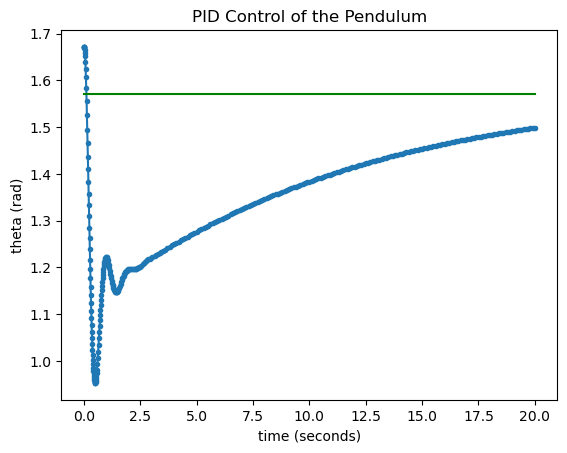

In [7]:
# Set up a simulator to run this diagram.
simulator = Simulator(diagram)
context = simulator.get_mutable_context()

# We'll try to regulate the pendulum to a particular angle.
desired_angle = np.pi/2.

# First we extract the subsystem context for the pendulum.
pendulum_context = diagram.GetMutableSubsystemContext(pendulum, context)
# Then we can set the pendulum state, which is (theta, thetadot).
pendulum_context.get_mutable_continuous_state_vector().SetFromVector(
    [desired_angle + 0.1, 0.2])

# The diagram has a single input port (port index 0), which is the desired_state.
diagram.get_input_port(0).FixValue(context, [desired_angle, 0.])

# Clear the logger only because we've written this notebook with the opportunity to
# simulate multiple times (in this cell) using the same logger object.  This is
# often not needed.
logger.FindMutableLog(context).Clear()

# Simulate for 10 seconds.
simulator.AdvanceTo(20);

# Plot the results.
log = logger.FindLog(simulator.get_context())
t = log.sample_times()
plt.figure()
# Plot theta.
plt.plot(t, log.data()[0,:],'.-')
# Draw a line for the desired angle.
plt.plot([t[0], t[-1]], [desired_angle, desired_angle], 'g' )
plt.xlabel('time (seconds)')
plt.ylabel('theta (rad)')
plt.title('PID Control of the Pendulum');

## Advanced tutorials
- [Authoring Leaf Systems](./authoring_leaf_systems.ipynb)
- [Working with Diagrams](./working_with_diagrams.ipynb)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2b4fc509-aef2-417d-a40d-6071dfed9199' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>